# Analyze Results from Classification models

<h2>Background</h2>

I found that running different models through Jupyter notebook just wasn't stable enough. The process would either crash or hang and found the speed much slower than if I ran them as a standalone programs. I also found that if I broke the steps down into different programs, it would run faster and was more reliable for me to check on results.

Here is a list of programs that I used to generate various feature files and results:

| File Name | Description | Helper Classes | Sample Config File |
|-----------|-------------|----------------|--------------------|
| [tsv_to_csv.py](tsv_to_csv.py) | I found that pandas did not handle reading in raw amazong review files (tsv) correctly. There were line breaks in the data file that caused pandas to be confused and would merge in multiple lines into one column cell which would sku the data. Needed to write this to convert the tsv to csv so pandas can read the data properly | N/A | N/A |
| [amazon_review_preprocessor.py](amazon_review_preprocessor.py) | Takes in converted amazon review csv file does pre-processing/cleaning of the data | [util.TextProcessor.py](util/TextProcessor.py) | N/A |
| [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py) | Takes in preprocessed file generated from [amazon_review_preprocessor.py](amazon_review_preprocessor.py) and generate BoW or TFIDF feature files with different parameters. Parameters supported: various max_df, min_df, ngrams | [nlp.feature_util.py](nlp/feature_util.py) | [2019-05-21-amazon_review_feature_generation_config-bow.py](config/2019-05-21-amazon_review_feature_generation_config-bow.csv) |
| [generate_lda_features.py](generate_lda_features.py) | After processing data through [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py), I used this program to do Topic Modeling using LDA with this program. Current setting picks 20 topics and generate resulting data files | N/A | [2019-05-21-amazon_review_generate_lda_feature_config-tfidf.cvs](config/2019-05-21-amazon_review_generate_lda_feature_config-tfidf.csv) |
| [run_classifiers.py](run_classifiers.py) | This was originally a python notebook that would take hours and hours to run. But the original notebook also combined the function of generating BoW and TF-IDF with various parameters encoding as well as running KNN and LogisticRegression with various parameters. This also generates reports using sklearn's classification_report for different models which we will interpret here. | [models/ClassifierRunner.py](models.ClassifierRunner.py) | [2019-05-23-run_classifiers-config.csv](config/2019-05-23-run_classifiers-config.csv) |


<h2>Data and Models</h2>

Some issues that I ran into when trying to run various datasets against different models:

    * Radius Neighbor - documentation suggests that using RadiusNeighborClassifier my be a better choice if the sample is not uniform. My data heavily skewed towards 5-stars so I thought I would try this. However, I found that the radius was difficult to set and the value would change depending on sample size and number of features. Also, it was pretty slow to train. At times this would be slowers the Logistic Regression. I finally gave up on using this last night

    * Logistic Regression parameters - I tried using default settings for this which is 100. However, I found that it would not converge on most datasets that I used. Tried 200 then 300. 300 seems to at least come back with results so I stuck with this to start with

    * Time - had issues with this on multiple fronts
        * I found that generating feature files took quite some time especially using ngram. For dataset with 100k examples, it would take 3 to 4 hours to generate the files on my laptop
        * I found that Logistic Regression ran the slowest out of the 3 models. RN sometimes would be slower.  I found that running the models with large dataset look quite a long time. Since I'm running these on my work laptop, I couldn't just leave it running so had to take some measures to cut down on feature sizes. I did run some models on an hold laptop and found that some feature sizes and model combination was taking more than a day to run so had to abandon that as well.
        
    * Storage - generating various feature file without using BoW and TF-IDF was taking up a lot of space on my laptop. I found that once I converted them into BoW or TF-IDF representation, the files would get much smaller. I did run out of storage on my machine multiple times and my program would stop working because of this.
    

<h3>ngram</h3>

I did try to generate features using ngram. However, I did find that this dramatically increased the feature matrix size. For a file that has ~100k entries. 47k unique features (unique word) would generated by BoW or TF-IDF. For the most part I did not use ngram without using min_df and max_df because I had issues with time needed to create feature files, storage, as well as issues with being able to complete the models when I used ngram alone

| Sample Size | Features no ngram | ngram (1,2) | ngram (1,3) |
|------|------|------|---|
| 999 | 3323 | 17k | 32k |

<h3>min_df and max_df</h3>

I found that using these parameters with setting of min_df=0.05 and max_df=0.95 effectively cut down the feature set size drastically. When using this for review body, if we use 100k examples, this reduced it to about 56 features.

<h3>LDA</h3>

Used LDA for topic modeling. Wasn't sure how many topics would be reasonable here. So for now I picked 20 topics. May play around with this more later



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [34]:
DATA_FILE="reports/2019-05-23-run_classifiers-999-report.csv"

report = pd.read_csv(DATA_FILE)
report["total_size"] = report["train_examples"] + report["test_examples"]
report.head()

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,test_features,total_time_min,train_examples,train_features,train_time_min,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,total_size
0,0.363636,0.333333,0.400,40.0,0.0,0.0,0.0,13.0,0.0,0.0,...,10.0,0.0,749.0,10.0,0.0,0.471012,0.433789,0.520,250.0,999.0
1,0.000000,0.000000,0.000,40.0,0.0,0.0,0.0,13.0,0.0,0.0,...,10.0,0.0,749.0,10.0,0.0,0.411510,0.322624,0.568,250.0,999.0
2,0.333333,0.642857,0.225,40.0,0.0,0.0,0.0,13.0,0.0,0.0,...,10.0,0.0,749.0,10.0,0.0,0.484102,0.590686,0.600,250.0,999.0
3,0.363636,0.333333,0.400,40.0,0.0,0.0,0.0,13.0,0.0,0.0,...,10.0,0.0,749.0,10.0,0.0,0.471012,0.433789,0.520,250.0,999.0
4,0.000000,0.000000,0.000,40.0,0.0,0.0,0.0,13.0,0.0,0.0,...,10.0,0.0,749.0,10.0,0.0,0.411510,0.322624,0.568,250.0,999.0


## Description of which models we ran

Description Uses the following format

(classification model)-(column)-(feature extraction method)-(max/min df setting)-(ngram setting)-(sample size)[-(lda)]

    classification model
        which model we used to train and predict
    column
        which column in Amazon Reviews data set we used to create the feature set
    feature extraction method
        bow = Bag of Words
        tfidf = TF-IDF
    max/min df setting
        df_none = default settings for min_df and max_df
        df90 = min_df of 0.05 and max_df of 0.95
        df80 = min_df of 0.10 and max_def of 0.9
    ngram setting
        ngram1 = (1,1)
        ngram12 = (1,2)
        ngram13 = (1,3)
    lda
        Indicates whether LDA was used on top of feature extraction method. Currently using 20 topics

In [81]:
def split_desc(x):
    desc = x["description"]
    s_desc = desc.split("-")
    if len(s_desc) == 6:
        s_desc.append("n/a")
#     print(f'desc: {desc} len: {len(s_desc)}')
    return pd.Series(s_desc)
    

s = report[["description","status"]].copy()
# s["feature_column"], s["method"], s["df"], s["ngram"], _, _, s["lda"] = s.apply(split_desc, axis=1)
new_df = s.apply(split_desc, axis=1)
s.join(new_df)

,description,status,0,1,2,3,4,5,6
0,review_body-bow-df_80-ngram1-999-10,success,review_body,bow,df_80,ngram1,999,10,n/a
1,review_body-bow-df_80-ngram1-999-10,success,review_body,bow,df_80,ngram1,999,10,n/a
2,review_body-bow-df_80-ngram1-999-10,success,review_body,bow,df_80,ngram1,999,10,n/a
3,review_body-bow-df_80-ngram12-999-10,success,review_body,bow,df_80,ngram12,999,10,n/a
4,review_body-bow-df_80-ngram12-999-10,success,review_body,bow,df_80,ngram12,999,10,n/a
5,review_body-bow-df_80-ngram12-999-10,success,review_body,bow,df_80,ngram12,999,10,n/a
6,review_body-bow-df_80-ngram13-999-10-lda20,success,review_body,bow,df_80,ngram13,999,10,lda20
7,review_body-bow-df_80-ngram13-999-10-lda20,success,review_body,bow,df_80,ngram13,999,10,lda20
8,review_body-bow-df_80-ngram13-999-10-lda20,success,review_body,bow,df_80,ngram13,999,10,lda20
9,review_body-bow-df_80-ngram13-999-10,success,review_body,bow,df_80,ngram13,999,10,n/a


In [ ]:
report["label"] = report.apply(lambda x: f'{x["model_name"]}-{x["description"]}', axis=1)
report = report.drop(labels=["model_name", "description"], axis=1).sort_values(["label"])

## Overall Scores

In [7]:

overall_scores = report[["label",
                         "macro avg_f1-score", "macro avg_precision", "macro avg_recall"]].copy()
overall_scores.head()

,label,macro avg_f1-score,macro avg_precision,macro avg_recall
0,KNN-review_body-bow-df_80-ngram1-999-10,0.233129,0.220797,0.252554
3,KNN-review_body-bow-df_80-ngram12-999-10,0.233129,0.220797,0.252554
9,KNN-review_body-bow-df_80-ngram13-999-10,0.233129,0.220797,0.252554
6,KNN-review_body-bow-df_80-ngram13-999-10-lda20,0.273624,0.315122,0.291121
12,KNN-review_body-bow-df_90-ngram1-999-35,0.331896,0.379861,0.332168


Text(0.5, 1.0, 'Logistic Regression Macro Average Scores')

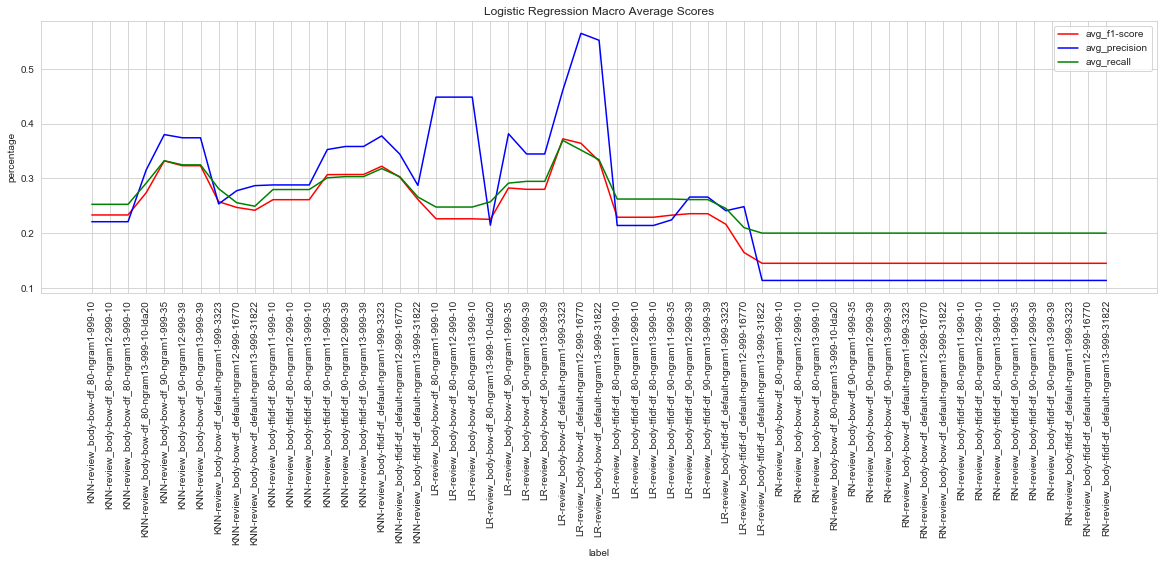

In [32]:
sns.set_style("whitegrid")
f, a = plt.subplots(1, 1, figsize=(20,5))

g = sns.lineplot(data=overall_scores, x="label", y="macro avg_f1-score", label="avg_f1-score", ax=a, color="r")
g = sns.lineplot(data=overall_scores, x="label", y="macro avg_precision", label="avg_precision", ax=a, color="b")
g = sns.lineplot(data=overall_scores, x="label", y="macro avg_recall", label="avg_recall", ax=a, color="g")
g.set_xticklabels(labels=overall_scores["label"], rotation=90)
g.set_ylabel("percentage")
g.set_title("Logistic Regression Macro Average Scores")


### Looks like LR has a slightly higher mean and smaller standard deviation for F1 Score

In [9]:
o_LR = overall_scores[overall_scores["label"].str.contains("LR")]
print(f'LR mean: {o_LR["macro avg_f1-score"].mean()}')
print(f'LR std: {o_LR["macro avg_f1-score"].std()}')

o_KNN = overall_scores[overall_scores["label"].str.contains("KNN")]
print(f'KNN mean: {o_KNN["macro avg_f1-score"].mean()}')
print(f'KNN std: {o_KNN["macro avg_f1-score"].std()}')

o_RN = overall_scores[overall_scores["label"].str.contains("RN")]
print(f'RN mean: {o_RN["macro avg_f1-score"].mean()}')
print(f'RN std: {o_RN["macro avg_f1-score"].std()}')


LR mean: 0.24891317155095696
LR std: 0.058312120730474225
KNN mean: 0.2782181619987117
KNN std: 0.03487835599751251
RN mean: 0.14489795918367349
RN std: 2.851614316424119e-17


### With a p-value of > 5%, looks like the difference in F1 score is NOT statistically significant as of this point

In [10]:
from scipy.stats import ttest_ind
stat, p = ttest_ind(o_LR["macro avg_f1-score"], o_KNN["macro avg_f1-score"])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-1.880, p=0.068


### Top 5 Models and Datasets with Highest Average F1 Score

In [11]:
overall_scores.nlargest(5, "macro avg_f1-score")

,label,macro avg_f1-score,macro avg_precision,macro avg_recall
23,LR-review_body-bow-df_none-ngram1-999-3323,0.372086,0.460879,0.369141
26,LR-review_body-bow-df_none-ngram12-999-16770,0.363919,0.564615,0.351552
12,KNN-review_body-bow-df_90-ngram1-999-35,0.331896,0.379861,0.332168
29,LR-review_body-bow-df_none-ngram13-999-31822,0.331487,0.551990,0.333856
15,KNN-review_body-bow-df_90-ngram12-999-39,0.323040,0.373995,0.324579


## F1 Score By Class

In [12]:
f1_class = report[["label", "1_f1-score", "2_f1-score", "3_f1-score", "4_f1-score", "5_f1-score"]].copy()
f1_class.head()

,label,1_f1-score,2_f1-score,3_f1-score,4_f1-score,5_f1-score
0,KNN-review_body-bow-df_80-ngram1-999-10,0.363636,0.000000,0.000000,0.101695,0.700315
3,KNN-review_body-bow-df_80-ngram12-999-10,0.363636,0.000000,0.000000,0.101695,0.700315
9,KNN-review_body-bow-df_80-ngram13-999-10,0.363636,0.000000,0.000000,0.101695,0.700315
6,KNN-review_body-bow-df_80-ngram13-999-10-lda20,0.418605,0.000000,0.117647,0.170213,0.661654
12,KNN-review_body-bow-df_90-ngram1-999-35,0.465116,0.117647,0.083333,0.222222,0.771160


In [19]:
f1_LR = f1_class[f1_class["label"].str.startswith("LR")]
f1_KNN = f1_class[f1_class["label"].str.startswith("KNN")]
f1_RN = f1_class[f1_class["label"].str.startswith("RN")]

In [20]:
f1_LR.describe()

,1_f1-score,2_f1-score,3_f1-score,4_f1-score,5_f1-score
count,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.372970,0.017924,0.038984,0.047469,0.767219
std,0.140930,0.042595,0.065283,0.056900,0.021744
min,0.000000,0.000000,0.000000,0.000000,0.724490
25%,0.333333,0.000000,0.000000,0.000000,0.748998
50%,0.371429,0.000000,0.000000,0.048780,0.773481
75%,0.466738,0.000000,0.083333,0.052632,0.780144
max,0.564706,0.117647,0.200000,0.200000,0.808642


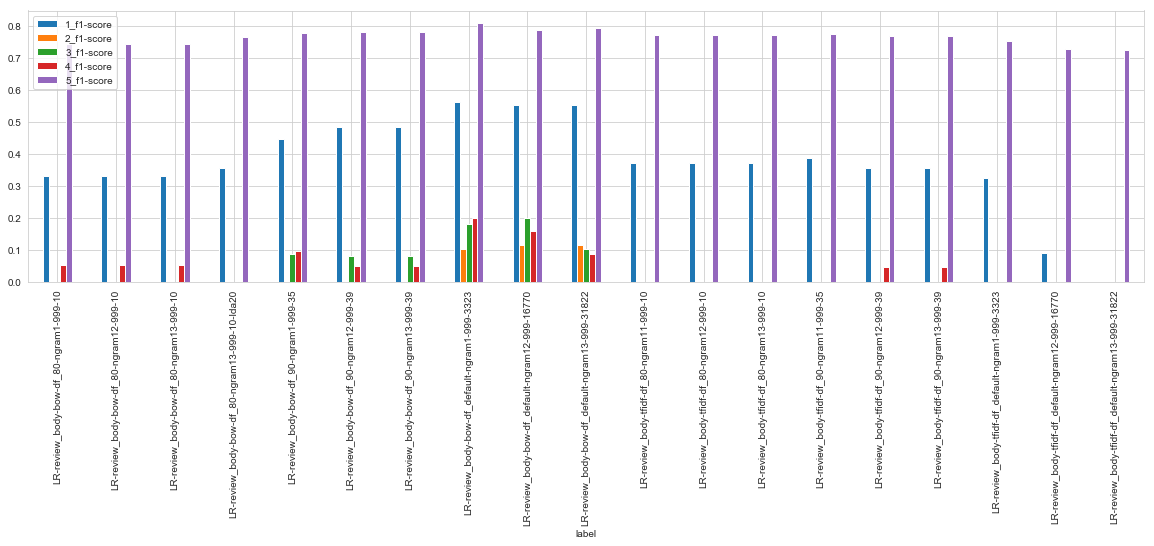

In [29]:
# bar plot by F1 scores
f1_LR.set_index("label").plot(kind='bar', figsize=(20,5))

In [22]:
f1_KNN.describe()

,1_f1-score,2_f1-score,3_f1-score,4_f1-score,5_f1-score
count,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.400984,0.043581,0.066479,0.139027,0.741020
std,0.047189,0.052910,0.064794,0.042886,0.032901
min,0.342857,0.000000,0.000000,0.081633,0.661654
25%,0.363636,0.000000,0.000000,0.101695,0.712715
50%,0.400000,0.000000,0.058824,0.145455,0.753165
75%,0.439746,0.097619,0.090909,0.168440,0.767372
max,0.513514,0.117647,0.222222,0.222222,0.775758


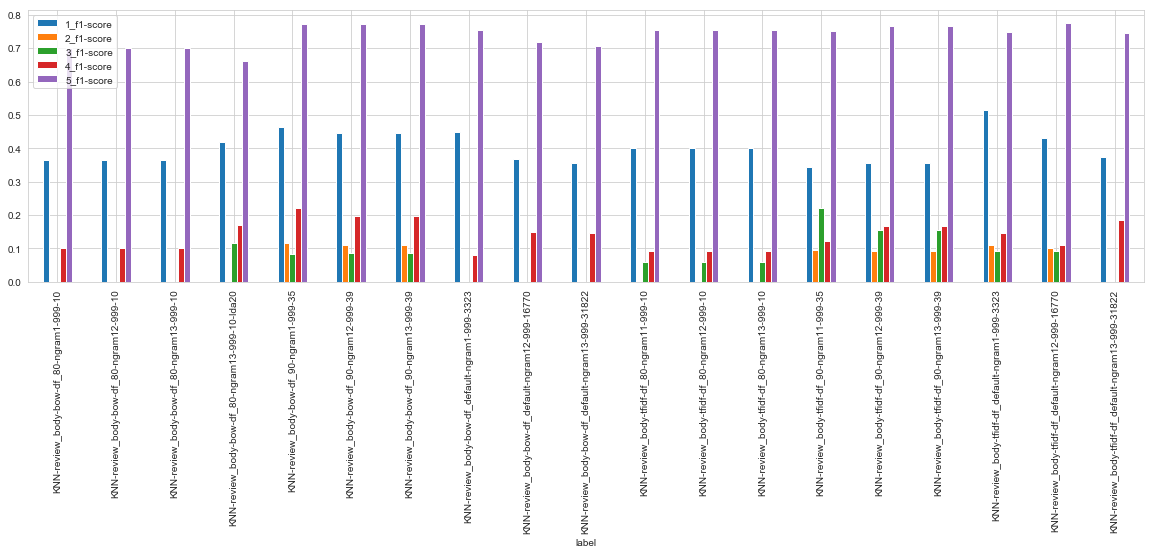

In [30]:
# KNN
f1_KNN.set_index("label").plot(kind='bar', figsize=(20,5))


In [24]:
if len(f1_RN) > 1:
    f1_RN.describe()

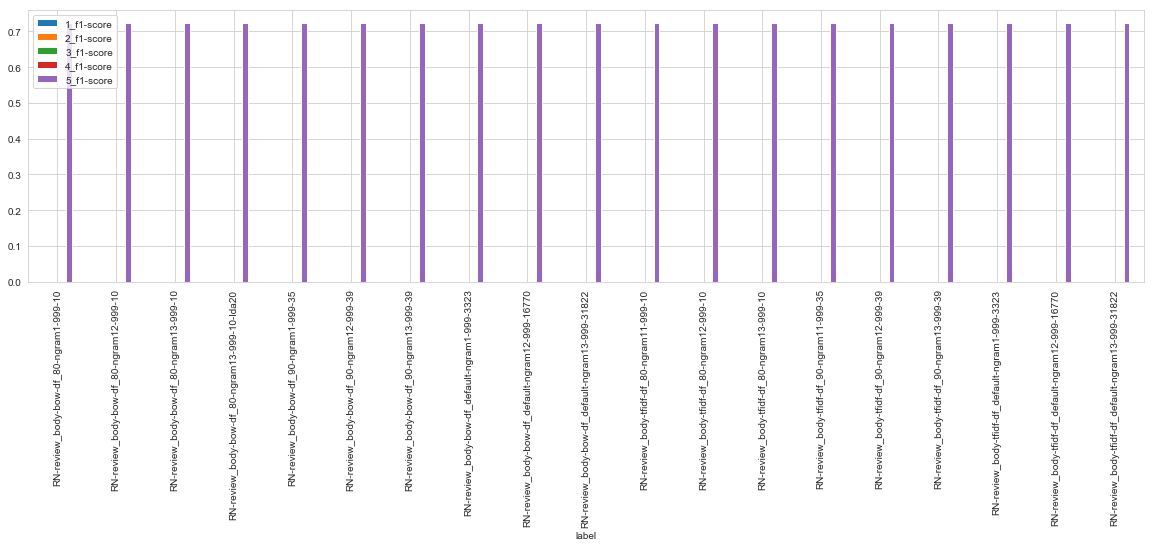

In [31]:
# Radius Neighbor
if len(f1_RN) > 1:
    f1_RN.set_index("label").plot(kind='bar', figsize=(20,5))

## Let's look at top 5 models

In [28]:
f1_class.nlargest(5, ["1_f1-score", "2_f1-score", "3_f1-score", "4_f1-score", "5_f1-score"])

,label,1_f1-score,2_f1-score,3_f1-score,4_f1-score,5_f1-score
23,LR-review_body-bow-df_none-ngram1-999-3323,0.564706,0.105263,0.181818,0.200000,0.808642
26,LR-review_body-bow-df_none-ngram12-999-16770,0.552632,0.117647,0.200000,0.160000,0.789318
29,LR-review_body-bow-df_none-ngram13-999-31822,0.552632,0.117647,0.105263,0.088889,0.793003
48,KNN-review_body-tfidf-df_none-ngram1-999-3323,0.513514,0.111111,0.090909,0.145455,0.749245
17,LR-review_body-bow-df_90-ngram12-999-39,0.485714,0.000000,0.083333,0.050000,0.780627
